In [4]:
%matplotlib inline
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt

#from torchsummary import summary
import torch
from torch import nn, optim
from torch.autograd import Variable
import time
from time import strftime, localtime
import copy
import random

In [5]:
torch.cuda.get_device_name(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [29]:
# Parameters

T = 180     # 3 min of data, sampled every 0.1 s
fs = 10
N = T*fs
t = np.linspace(0,T,N)

# These vary..

freq_sin = np.random.uniform(0.0, 1.0, 1000)                # frequency of sine wave
phase_shift_sin = np.random.uniform(0.0, 2.0*np.pi, 1000)    # phase of sine wave
t0_sg = np.random.uniform(0.0, T, 1000)                      # pulse starting time of sine gaussian

# These are fixed

a = 0.1
phi0 = np.pi
f0 = 0.5
tau = 10.0

In [30]:
# Time Series

ts_s_train = np.zeros((1000,N))
ts_sg_train = np.zeros((1000,N))

# noise
# noise = np.random.normal(loc=0.0, scale=10.0, size=1000)

for i in range(1000):
    
    ts_s_train[i,:] = a*np.sin(2*np.pi*freq_sin[i]*t + phase_shift_sin[i]) #+ noise
    ts_sg_train[i,:] = a*(np.exp(-(t-t0_sg[i])**2/tau**2))*(np.cos(2*np.pi*f0*(t-t0_sg[i])+phi0)) #+ noise
    
    ts_mix_train = ts_s_train + ts_sg_train
    


(1000, 1800)
(1000, 1800)
(1000, 1800)


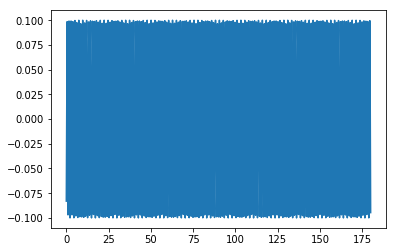

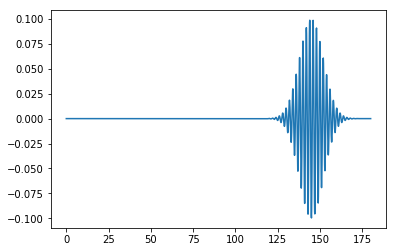

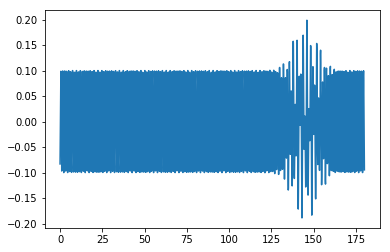

In [31]:
print(ts_s_train.shape)
print(ts_sg_train.shape)
print (ts_mix_train.shape)

# Time series examples

plt.plot(t, ts_s_train[0,:])
plt.show()
plt.plot(t, ts_sg_train[0,:])
plt.show()
plt.plot(t, ts_mix_train[0,:])
plt.show()

In [40]:
class CDAE(nn.Module):
    
    def __init__(self):
        
        super(CDAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 15, kernel_size = 3, stride=1),
            torch.nn.Dropout(0.1)
            nn.ReLU(True),
            nn.Conv1d(15, 30, kernel_size = 3, stride=1),
            torch.nn.Dropout(0.1)
            nn.ReLU(True),
            nn.Conv1d(30, 8, kernel_size = 3, stride=1),
            torch.nn.Dropout(0.1)
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(8, 30, kernel_size = 3, stride=1),
            nn.ReLU(True),
            nn.ConvTranspose1d(30, 15, kernel_size = 3, stride=1),
            nn.ReLU(True),
            nn.ConvTranspose1d(15, 1, kernel_size = 3, stride=1),
            nn.ReLU()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

SyntaxError: invalid syntax (<ipython-input-40-e2855c0dc503>, line 9)

In [41]:
# Hyperparameters

num_epochs = 1000
batch_size = 20
lr = 0.001

0


/home/nataliak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


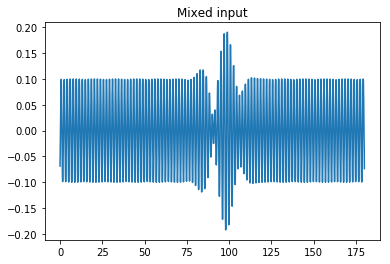

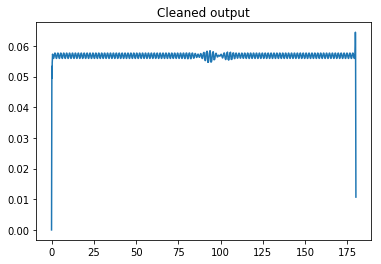

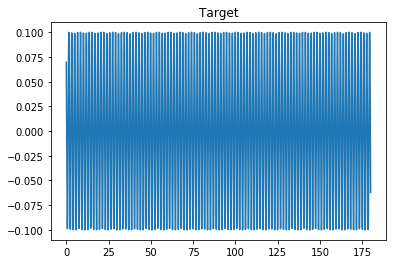

100


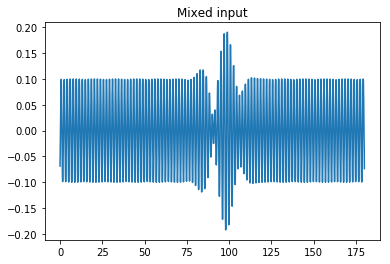

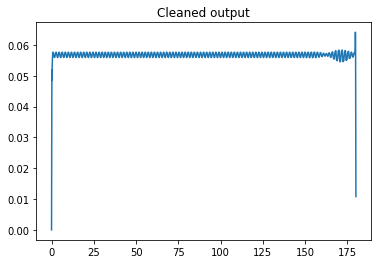

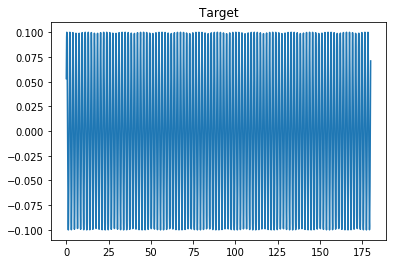

200


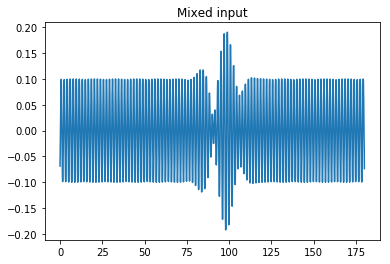

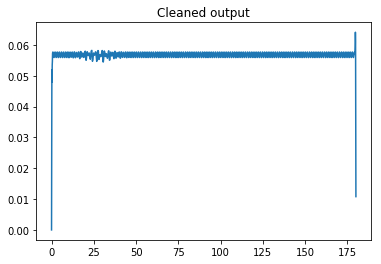

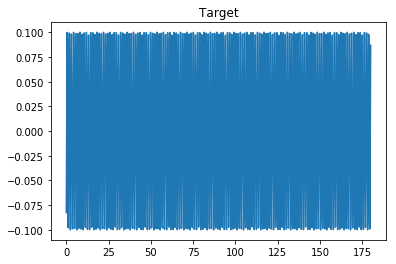

300


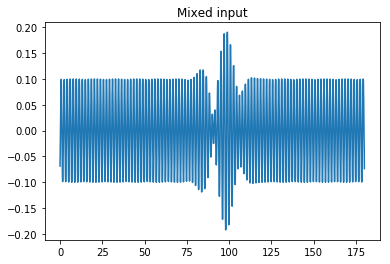

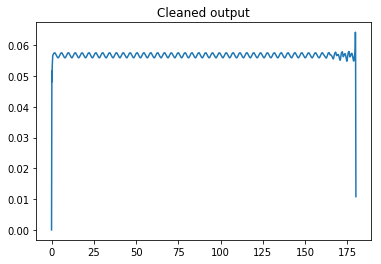

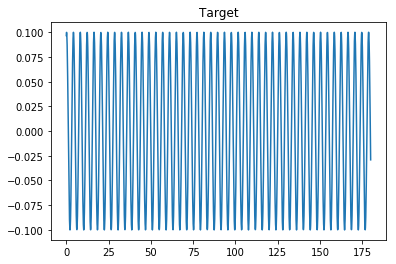

400


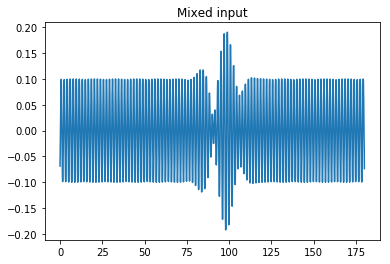

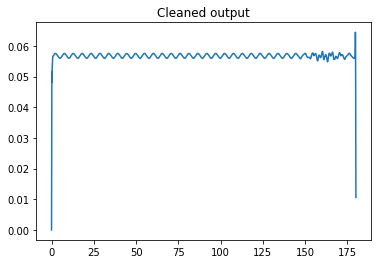

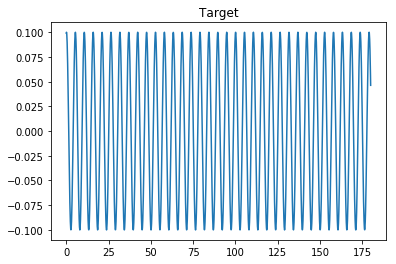

500


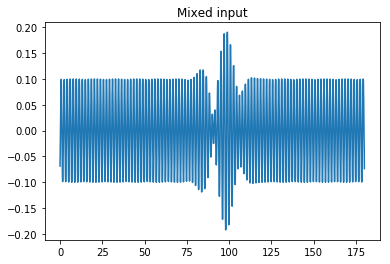

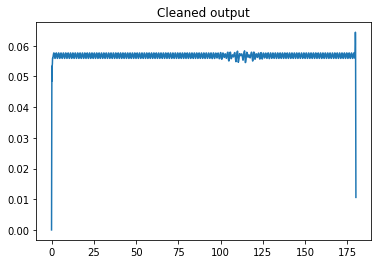

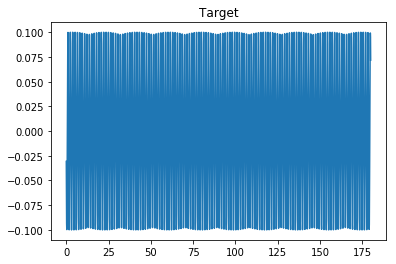

600


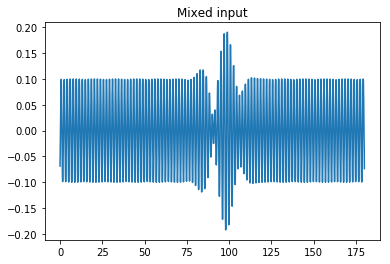

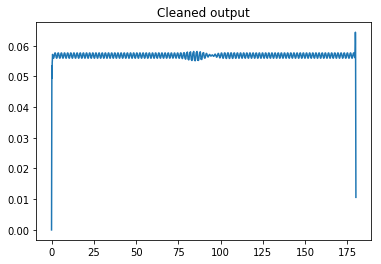

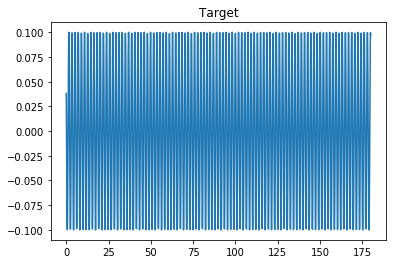

700


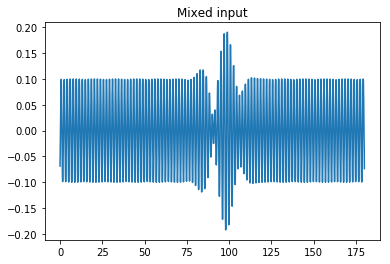

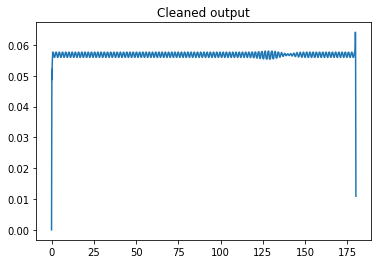

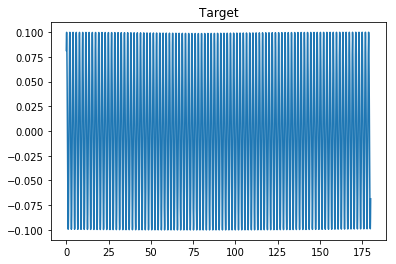

800


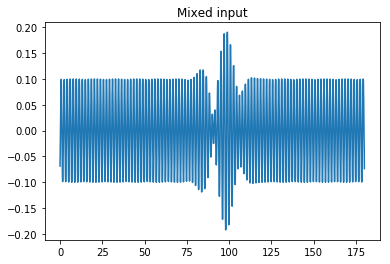

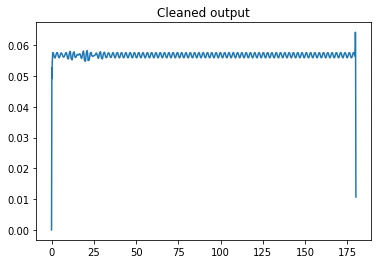

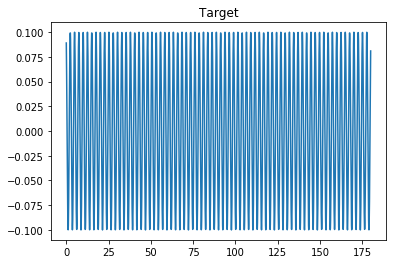

900


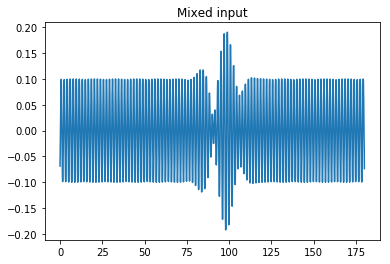

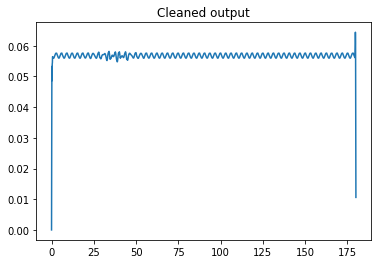

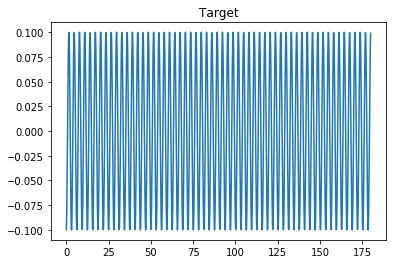

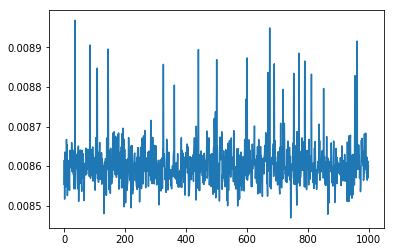

In [57]:

inputs = Variable(torch.from_numpy(ts_mix_train)).to(device)
inputs = inputs.reshape(-1,1,N)
inputs = inputs.type(torch.cuda.FloatTensor)

ae_net = CDAE().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(test_net.parameters(), lr=lr,
weight_decay=1e-5)
loss_save = []
epoch = 0

for epoch in range(num_epochs):
    
    idx  = random.sample(list(np.arange(inputs.shape[0])),batch_size)
    
    outputs = ae_net(inputs[idx,:,:])
    
    clean = Variable(torch.from_numpy(ts_s_train)).to(device)
    clean = clean.reshape(-1,1,N)
    clean = clean.type(torch.cuda.FloatTensor)
    clean = clean[idx,:,:]
    
    loss = criterion(outputs, inputs[idx,:,:])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_save.append(loss.data[0])
    
    if epoch%100==0:
        print(epoch)
        plt.plot(t, inputs[1,:,:].reshape(N).cpu().numpy())
        plt.title('Mixed input')
        plt.show()
        plt.plot(t, outputs[1,:,:].reshape(N).detach().cpu().numpy())
        plt.title('Cleaned output')
        plt.show()
        plt.plot(t, clean[1,:,:].reshape(N).cpu().numpy())
        plt.title('Target')
        plt.show()

plt.plot(loss_save)